# Validação Cruzada

Validação cruzada é uma técnica para avaliar a capacidade de generalização de um modelo, ou seja, sua capacidade de prever corretamente dados não vistos anteriormente.

A ideia é dividir o conjunto de dados em $k$ partições, chamadas de folds, e realizar $k$ treinamentos e testes, cada um deles utilizando uma partição diferente como conjunto de teste e as demais como conjunto de treinamento. Ao final, calcula-se a média das métricas de avaliação obtidas em cada teste.

A figura abaixo ilustra o processo de validação cruzada com $k=4$.

![Validação cruzada](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

In [46]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, cohen_kappa_score, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Importando dados

In [6]:
data = fetch_openml(data_id=1523, parser='auto')

In [9]:
df = pl.DataFrame(data.data, schema=data.feature_names)
df.head()

V1,V2,V3,V4,V5,V6
f64,f64,f64,f64,f64,f64
63.027818,22.552586,39.609117,40.475232,98.672917,-0.2544
39.056951,10.060991,25.015378,28.99596,114.405425,4.564259
68.832021,22.218482,50.092194,46.613539,105.985136,-3.530317
69.297008,24.652878,44.311238,44.64413,101.868495,11.211523
49.712859,9.652075,28.317406,40.060784,108.168725,7.918501


In [26]:
classes = {
    '1': 'Disk Hernia',
    '2': 'Normal',
    '3': 'Spondylolisthesis'
}

df = df.with_columns(
    pl.Series(list(data.target)).map_dict(classes).alias('diagnostic'),
)

Removendo outliers

In [29]:
df = df.filter(
    pl.col('V6') <= 400
)

## Preparando os dados

In [30]:
X = df.select(
    pl.all().exclude('diagnostic')
)

y = df.select('diagnostic')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Normalizando dados

In [32]:
mms = MinMaxScaler()
mms.fit(X_train)

X_train_scaled = mms.transform(X_train)
X_test_scaled = mms.transform(X_test)

## Criando o Modelo

In [36]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train.to_numpy().ravel())
y_hat = knn.predict(X_test_scaled)

<Figure size 1000x1000 with 0 Axes>

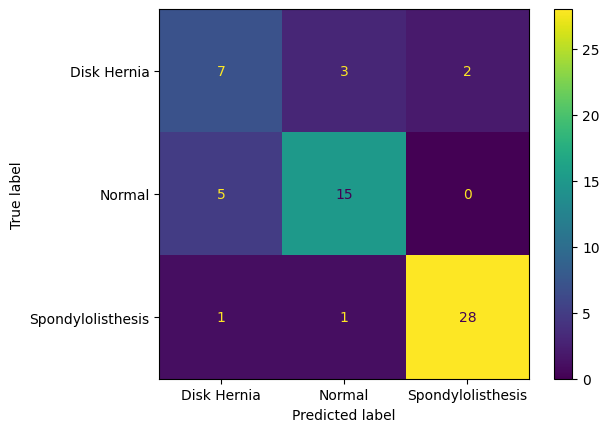

In [39]:
mc = confusion_matrix(y_test.to_numpy().ravel(), y_hat, labels=list(classes.values()))

figure = plt.figure(figsize=(10, 10))
display = ConfusionMatrixDisplay(mc, display_labels=list(classes.values()))
display.plot();

In [40]:
print(classification_report(y_test.to_numpy().ravel(), y_hat, target_names=list(classes.values())))

                   precision    recall  f1-score   support

      Disk Hernia       0.54      0.58      0.56        12
           Normal       0.79      0.75      0.77        20
Spondylolisthesis       0.93      0.93      0.93        30

         accuracy                           0.81        62
        macro avg       0.75      0.76      0.75        62
     weighted avg       0.81      0.81      0.81        62



### Utilizando validaçao cruzada

Idealmente devemos ter 3 conjuntos de dados: treinamento, validação e teste. No entanto, nem sempre temos dados suficientes para isso. Nesses casos, podemos utilizar a validação cruzada pem cima dos dados de treino.

In [43]:
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(knn, X_train_scaled, y_train.to_numpy().ravel(), cv=kfold)

print(f'K-fold (R2) Score: {results}')
print(f'K-fold (Mean R2) Score: {results.mean():.2f} (+/- {results.std():.2f})')

K-fold (R2) Score: [0.78       0.84       0.83673469 0.79591837 0.7755102 ]
K-fold (Mean R2) Score: 0.81 (+/- 0.03)


### Utilizando GridSearchCV para otimizar hiperparâmetros

In [48]:
error = []

for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train.to_numpy().ravel())
    y_hat = knn.predict(X_test_scaled)
    error.append(np.mean(y_hat != y_test.to_numpy().ravel()))

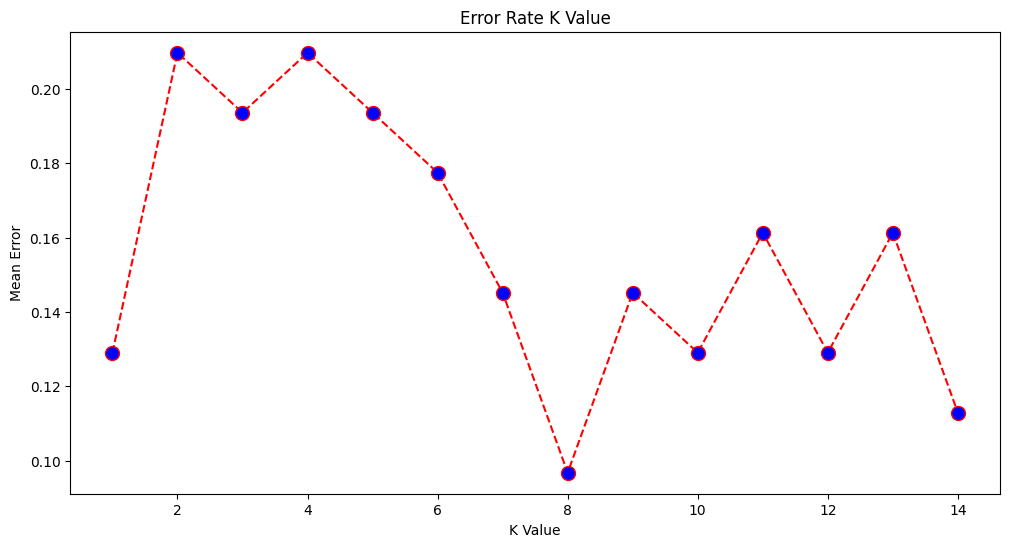

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error');

Podemos perceber que variando o número de vizinhos ($k$) o desempenho do modelo varia. Para encontrar o melhor valor de $k$, ou de outros parametros como o calculo de distância utilizado, podemos utilizar o GridSearchCV.

In [50]:
grid_param = {
    'n_neighbors': [8,14],
    'weights': ['uniform', 'distance'],
    'metric': ['cosine', 'euclidean', 'manhattan']
}

grid_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    scoring=grid_metric,
    verbose=3,
    cv=5,
    n_jobs=-1
    )

grid.fit(X_train_scaled, y_train.to_numpy().ravel())
knn_params = grid.best_params_

print(f'Best Parameters: {knn_params}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END metric=cosine, n_neighbors=8, weights=distance;, score=0.760 total time=   0.0s
[CV 2/5] END metric=cosine, n_neighbors=8, weights=distance;, score=0.780 total time=   0.0s
[CV 2/5] END metric=cosine, n_neighbors=8, weights=uniform;, score=0.760 total time=   0.0s
[CV 1/5] END metric=cosine, n_neighbors=8, weights=uniform;, score=0.760 total time=   0.0s
[CV 4/5] END metric=cosine, n_neighbors=8, weights=uniform;, score=0.796 total time=   0.0s
[CV 3/5] END metric=cosine, n_neighbors=8, weights=distance;, score=0.796 total time=   0.0s
[CV 5/5] END metric=cosine, n_neighbors=8, weights=uniform;, score=0.837 total time=   0.0s
[CV 3/5] END metric=cosine, n_neighbors=8, weights=uniform;, score=0.776 total time=   0.0s
[CV 4/5] END metric=cosine, n_neighbors=8, weights=distance;, score=0.796 total time=   0.0s
[CV 5/5] END metric=cosine, n_neighbors=8, weights=distance;, score=0.878 total time=   0.0s
[CV 1/5] END m

In [51]:
grid.cv_results_

{'mean_fit_time': array([0.00045819, 0.00054035, 0.00039101, 0.00037618, 0.00044641,
        0.00039034, 0.00041599, 0.00038018, 0.00037522, 0.00037932,
        0.00037489, 0.00032277]),
 'std_fit_time': array([2.17536017e-05, 1.06052979e-04, 2.13290705e-05, 2.48374035e-05,
        3.08902899e-05, 4.72048075e-05, 3.76596919e-05, 7.17551362e-05,
        3.47487697e-05, 3.47692444e-05, 2.25759105e-05, 7.77317699e-06]),
 'mean_score_time': array([0.00283036, 0.00161834, 0.00206428, 0.0009419 , 0.00167727,
        0.00059586, 0.00161982, 0.00061331, 0.00149589, 0.00057716,
        0.00149884, 0.00057425]),
 'std_score_time': array([8.90536634e-04, 9.33668701e-04, 7.13242877e-05, 3.23883018e-05,
        6.25051490e-05, 4.86437943e-05, 4.68801501e-05, 3.64362877e-05,
        8.99272910e-05, 2.96665532e-05, 3.19977275e-05, 1.38804668e-05]),
 'param_metric': masked_array(data=['cosine', 'cosine', 'cosine', 'cosine', 'euclidean',
                    'euclidean', 'euclidean', 'euclidean', 'manha

### Testando vários tipos de modelos

In [52]:
def AplicaValidacaoCruzada(x_axis, y_axis):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC

    kfold = KFold(n_splits=10, shuffle=True)

    X = x_axis
    y = y_axis

    knn = KNeighborsClassifier(n_neighbors=8, metric='euclidean', weights='distance')
    knn.fit(X, y)

    rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    rf.fit(X, y)

    svm = SVC(kernel='linear', C=1, random_state=0)
    svm.fit(X, y)

    knn_scores = cross_val_score(knn, X, y, cv=kfold)
    rf_scores = cross_val_score(rf, X, y, cv=kfold)
    svm_scores = cross_val_score(svm, X, y, cv=kfold)

    dict_models = {
        'KNN': knn_scores.mean(),
        'Random Forest': rf_scores.mean(),
        'SVM': svm_scores.mean()
    }

    melhorModelo = max(dict_models, key=dict_models.get)

    print(f'KNN: {knn_scores.mean()}')
    print(f'Random Forest: {rf_scores.mean()}')
    print(f'SVM: {svm_scores.mean()}')
    print(f'Melhor Modelo: {melhorModelo}')



In [53]:
AplicaValidacaoCruzada(X_train_scaled, y_train.to_numpy().ravel())

KNN: 0.7856666666666666
Random Forest: 0.7853333333333334
SVM: 0.7976666666666666
Melhor Modelo: SVM
